In [1]:
import libsbml
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import pickle
import numpy as np
import os 
from copy import deepcopy
from collections import defaultdict

In [2]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [3]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        
        num_parameters = model.getReaction(i).getKineticLaw().getNumParameters()
        is_reversible = False
        if num_parameters == 2:
            is_reversible = True
            
        if is_reversible:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if is_reversible:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if is_reversible:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [4]:
convert_sbml_to_network('BIOMD0000000038.xml')

number reactions 10
number species 17


In [5]:
def alter_pathway(filename, reaction_number, parameter_number, output_filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    reaction = model.getReaction(reaction_number)
    kinetic_law = reaction.getKineticLaw()
    parameter = kinetic_law.getParameter(parameter_number)
    parameter.setValue(parameter.getValue() * 100)
    
    modified_sbml = libsbml.writeSBML(document, output_filename)

In [6]:
def generate_test_set(filename, description):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    base_dir = 'altered_pathways2'
    
    i = 0
    num_reactions = model.getNumReactions()
    for j in range(num_reactions):
        reaction = model.getReaction(j)
        kinetic_law = reaction.getKineticLaw()
        num_parameters = kinetic_law.getNumParameters()
        for k in range(num_parameters):
            parameter = kinetic_law.getParameter(k)
            os.makedirs(os.path.join(base_dir, 'reaction' + str(i)), exist_ok=True)
            alteration_dir = os.path.join(base_dir, 'reaction' + str(i), 'reaction_' + str(i) + '_100x.xml')
            alter_pathway('BIOMD0000000038.xml', j, k, alteration_dir)
            
            altered_description = deepcopy(description)
            altered_description['altered'] = altered_description['reactions'][i][0]
            description_dir = os.path.join(base_dir, 'reaction' + str(i), 'description')
            description_file = open(description_dir, 'wb')
            pickle.dump(altered_description, description_file)
            description_file.close()
            i += 1

In [7]:
generate_test_set('BIOMD0000000038.xml', description)

In [8]:
description_path = 'altered_pathways2/reaction6/description'
description_file = open(description_path, 'rb')
temp = pickle.load(description_file)
description_file.close()
temp

{'species': ['EI',
  'PyrPI',
  'EIP',
  'HPr',
  'EIPHPr',
  'HPrP',
  'EIIA',
  'HPrPIIA',
  'EIIAP',
  'EIICB',
  'EIIAPIICB',
  'EIICBP',
  'EIICBPGlc',
  'PEP',
  'Pyr',
  'GlcP',
  'Glc'],
 'reactions': [['v1', 0, 1],
  ['v1revert', 0, 1],
  ['v2', 0, 1],
  ['v2revert', 0, 1],
  ['v3', 0, 1],
  ['v3revert', 0, 1],
  ['v4', 0, 1],
  ['v4revert', 0, 1],
  ['v5', 0, 1],
  ['v5revert', 0, 1],
  ['v6', 0, 1],
  ['v6revert', 0, 1],
  ['v7', 0, 1],
  ['v7revert', 0, 1],
  ['v8', 0, 1],
  ['v8revert', 0, 1],
  ['v9', 0, 1],
  ['v9revert', 0, 1],
  ['v10', 0, 1],
  ['v10revert', 0, 1]],
 'connections': [['PEP', 'v1'],
  ['v1revert', 'PEP'],
  ['EI', 'v1'],
  ['v1revert', 'EI'],
  ['v1', 'PyrPI'],
  ['PyrPI', 'v1revert'],
  ['PyrPI', 'v2'],
  ['v2revert', 'PyrPI'],
  ['v2', 'EIP'],
  ['EIP', 'v2revert'],
  ['v2', 'Pyr'],
  ['Pyr', 'v2revert'],
  ['HPr', 'v3'],
  ['v3revert', 'HPr'],
  ['EIP', 'v3'],
  ['v3revert', 'EIP'],
  ['v3', 'EIPHPr'],
  ['EIPHPr', 'v3revert'],
  ['EIPHPr', 'v4'],
  

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways2')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways2', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000038.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )
    
    '''complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()'''
        
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=False, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
         
    print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
    complete_results[directory] = correct_count / total_count
    

Converged at time 2.0
Converged at time 2.0
Specie:  EI expected result:  increased  normal final:  0.3555667827720005  altered final:  3.4976845099408904
confidence interval:  [0.9745386617472259, 0.9783868447815454]
deltas coming from simulation:  [3.14211772716889, 0]
Specie:  PyrPI expected result:  decreased  normal final:  3.2847518352229397  altered final:  0.328894320252799
confidence interval:  [0.017961951221132998, 0.021344326966777113]
deltas coming from simulation:  [-2.9558575149701407, 0]
Specie:  EIP expected result:  decreased  normal final:  0.8412593171673418  altered final:  0.08649364281132166
confidence interval:  [0.42203934944562393, 0.43391850792591774]
deltas coming from simulation:  [-0.7547656743560202, 0]
Specie:  HPr expected result:  increased  normal final:  0.6162452578629637  altered final:  12.566559710825857
confidence interval:  [0.5795586728058123, 0.5855488720043216]
deltas coming from simulation:  [11.950314452962893, 0]
Specie:  EIPHPr expected 

In [3]:
scores = []
for experiment in complete_results.keys():
    scores.append(complete_results[experiment])
print('Average score: ', np.average(np.array(scores)))

Average score:  0.85


In [4]:
results_path = '../../../results/real_dataset/large_class/results'
results_file = open(results_path, 'rb')
partial_results = pickle.load(results_file)
results_file.close()
partial_results

{'total_species': 2286,
 'uncertain_species': 35,
 'correct_species': 1584,
 'true_positives': 763,
 'false_positives': 382,
 'false_negatives': 320,
 'true_negatives': 821}

In [4]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  340  correct:  289  uncertain:  0  true pos:  144  true neg:  145  false_pos:  26 false neg:  25


In [6]:
partial_results['total_species'] += total_species
partial_results['uncertain_species'] += uncertain_species
partial_results['correct_species'] += correct_species
partial_results['true_positives'] += true_positives
partial_results['false_positives'] += false_positives
partial_results['true_negatives'] += true_negatives
partial_results['false_negatives'] += false_negatives

In [7]:
results_path = '../../../results/real_dataset/large_class/results'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

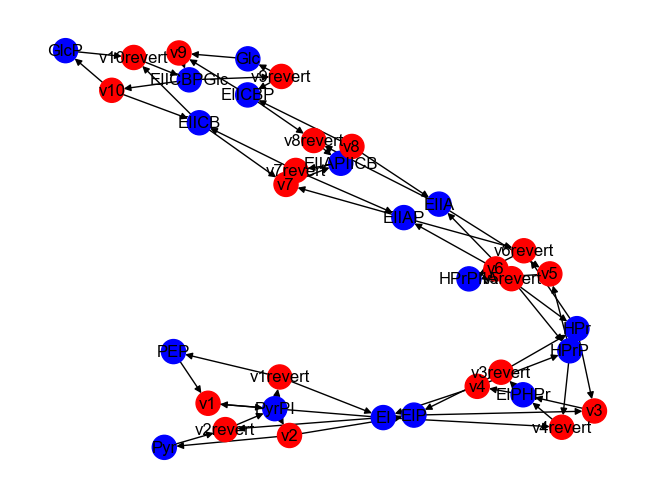

In [6]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [7]:
description_path = 'description_normal'
description_file = open(description_path, 'ab')
pickle.dump(description, description_file)
description_file.close()

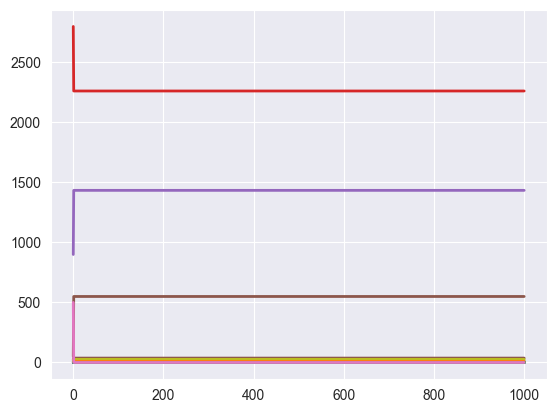

       time,     [EI], [PyrPI],    [EIP],    [HPr], [EIPHPr],  [HPrP],   [EIIA], [HPrPIIA], [EIIAP],  [EIICB], [EIIAPIICB], [EIICBP], [EIICBPGlc],   [PEP],   [Pyr], [GlcP],       [Glc]
 [[       0,        3,       0,        2,       25,        0,      25,       20,         0,      20,        5,           0,        5,           0,    2800,     900,     50,         500],
  [   1.001, 0.355567, 3.28475, 0.841259, 0.616245, 0.518422, 36.4504, 0.340598,   12.4149, 26.1471, 0.041971,     1.09742,  8.86059, 2.59695e-05, 2262.39, 1434.33,    550, 4.38509e-06],
  [   2.002, 0.355567, 3.28475, 0.841259, 0.616245, 0.518422, 36.4504, 0.340598,   12.4149, 26.1471, 0.041971,     1.09742,  8.86059, 2.59695e-05, 2262.39, 1434.33,    550, 4.38509e-06],
  [   3.003, 0.355567, 3.28475, 0.841259, 0.616245, 0.518422, 36.4504, 0.340598,   12.4149, 26.1471, 0.041971,     1.09742,  8.86059, 2.59695e-05, 2262.39, 1434.33,    550, 4.38509e-06],
  [   4.004, 0.355567, 3.28475, 0.841259, 0.616245, 0.518422, 36.45

In [5]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000038.xml')

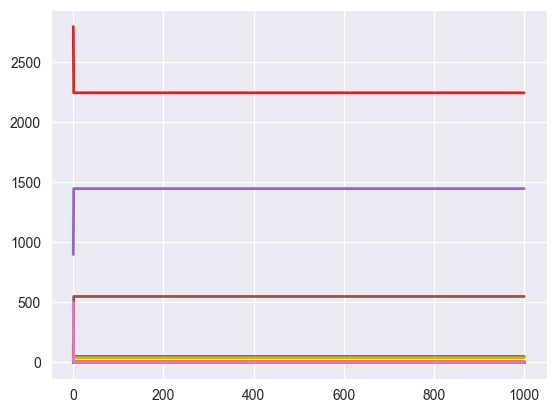

       time,       [EI], [PyrPI],   [EIP],      [HPr],   [EIPHPr],  [HPrP],     [EIIA], [HPrPIIA], [EIIAP],     [EIICB], [EIIAPIICB], [EIICBP], [EIICBPGlc],   [PEP],   [Pyr], [GlcP],       [Glc]
 [[       0,          3,       0,       2,         25,          0,      25,         20,         0,      20,           5,           0,        5,           0,    2800,     900,     50,         500],
  [   1.001, 0.00433529, 3.97828, 1.00876, 0.00854734, 0.00862224, 49.7213, 0.00526019,  0.261544, 39.7141, 0.000480699,   0.0190905,  9.98043, 2.97433e-07, 2247.31, 1448.71,    550, 4.45878e-08],
  [   2.002, 0.00433529, 3.97828, 1.00876, 0.00854734, 0.00862224, 49.7213, 0.00526019,  0.261544, 39.7141, 0.000480699,   0.0190905,  9.98043, 2.97433e-07, 2247.31, 1448.71,    550, 4.45878e-08],
  [   3.003, 0.00433529, 3.97828, 1.00876, 0.00854734, 0.00862224, 49.7213, 0.00526019,  0.261544, 39.7141, 0.000480699,   0.0190905,  9.98043, 2.97433e-07, 2247.31, 1448.71,    550, 4.45878e-08],
  [   4.004, 0.00

In [6]:
final_concentrations_altered = functions.plot_simulation_complete('BIOMOD0000000038_kf1_100x.xml')

In [7]:
species = description['species']
species

['EI',
 'PyrPI',
 'EIP',
 'HPr',
 'EIPHPr',
 'HPrP',
 'EIIA',
 'HPrPIIA',
 'EIIAP',
 'EIICB',
 'EIIAPIICB',
 'EIICBP',
 'EIICBPGlc',
 'PEP',
 'Pyr',
 'GlcP',
 'Glc']

In [8]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [9]:
final_normal

[1.00000000e+03 3.55566783e-01 3.28475184e+00 8.41259317e-01
 6.16245258e-01 5.18422065e-01 3.64504005e+01 3.40597965e-01
 1.24149322e+01 2.61470525e+01 4.19709742e-02 1.09741727e+00
 8.86058579e+00 2.59695389e-05 2.26238518e+03 1.43433007e+03
 5.49999970e+02 4.38508541e-06]

In [10]:
temp = final_concentrations_normal[1]
temp

[3.0e+00 0.0e+00 2.0e+00 2.5e+01 0.0e+00 2.5e+01 2.0e+01 0.0e+00 2.0e+01
 5.0e+00 0.0e+00 5.0e+00 0.0e+00 2.8e+03 9.0e+02 5.0e+01 5.0e+02]

In [11]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.01 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.01 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', delta2)

EI
final normal:  0.355566782772 final altered:  0.004335287345602158 delta:  -0.3512314954263978 relative delta  -0.9878073893410283 initial concentration:  3.0 delta1 0.11707716514213261 delta2 0.9878073893410283
PyrPI
final normal:  3.2847518352229352 final altered:  3.9782795442378296 delta:  0.6935277090148944 relative delta  0.21113549631910772 initial concentration:  0.0 delta1 0 delta2 0.21113549631910766
EIP
final normal:  0.8412593171673356 final altered:  1.0087629257786594 delta:  0.16750360861132385 relative delta  0.1991105538959583 initial concentration:  2.0 delta1 0.08375180430566193 delta2 0.19911055389595833
HPr
final normal:  0.6162452578633264 final altered:  0.008547342906426596 delta:  -0.6076979149568998 relative delta  -0.9861299656307907 initial concentration:  25.0 delta1 0.024307916598275994 delta2 0.9861299656307907
EIPHPr
final normal:  0.5184220648377106 final altered:  0.008622242637920365 delta:  -0.5097998221997903 relative delta  -0.9833682954049815 i

In [12]:
expected_results

{'EI': 'decreased',
 'PyrPI': 'unchanged',
 'EIP': 'increased',
 'HPr': 'decreased',
 'EIPHPr': 'unchanged',
 'HPrP': 'increased',
 'EIIA': 'decreased',
 'HPrPIIA': 'unchanged',
 'EIIAP': 'increased',
 'EIICB': 'unchanged',
 'EIIAPIICB': 'unchanged',
 'EIICBP': 'increased',
 'EIICBPGlc': 'unchanged',
 'PEP': 'unchanged',
 'Pyr': 'unchanged',
 'GlcP': 'unchanged',
 'Glc': 'unchanged'}

In [52]:
description_path = 'description_normal'
description_file = open(description_path, 'rb')
description = pickle.load(description_file)
description_file.close()
description

{'species': ['EI',
  'PyrPI',
  'EIP',
  'HPr',
  'EIPHPr',
  'HPrP',
  'EIIA',
  'HPrPIIA',
  'EIIAP',
  'EIICB',
  'EIIAPIICB',
  'EIICBP',
  'EIICBPGlc',
  'PEP',
  'Pyr',
  'GlcP',
  'Glc'],
 'reactions': [['v1', 0, 1],
  ['v1revert', 0, 1],
  ['v2', 0, 1],
  ['v2revert', 0, 1],
  ['v3', 0, 1],
  ['v3revert', 0, 1],
  ['v4', 0, 1],
  ['v4revert', 0, 1],
  ['v5', 0, 1],
  ['v5revert', 0, 1],
  ['v6', 0, 1],
  ['v6revert', 0, 1],
  ['v7', 0, 1],
  ['v7revert', 0, 1],
  ['v8', 0, 1],
  ['v8revert', 0, 1],
  ['v9', 0, 1],
  ['v9revert', 0, 1],
  ['v10', 0, 1],
  ['v10revert', 0, 1]],
 'connections': [['PEP', 'v1'],
  ['v1revert', 'PEP'],
  ['EI', 'v1'],
  ['v1revert', 'EI'],
  ['v1', 'PyrPI'],
  ['PyrPI', 'v1revert'],
  ['PyrPI', 'v2'],
  ['v2revert', 'PyrPI'],
  ['v2', 'EIP'],
  ['EIP', 'v2revert'],
  ['v2', 'Pyr'],
  ['Pyr', 'v2revert'],
  ['HPr', 'v3'],
  ['v3revert', 'HPr'],
  ['EIP', 'v3'],
  ['v3revert', 'EIP'],
  ['v3', 'EIPHPr'],
  ['EIPHPr', 'v3revert'],
  ['EIPHPr', 'v4'],
  

In [53]:
description['altered'] = 'v1'

In [26]:
description_path = 'description_v1_altered'
description_file = open(description_path, 'ab')
pickle.dump(description, description_file)
description_file.close()

In [14]:
description['reactions'][0][1] = 0.2
description

{'species': ['EI',
  'PyrPI',
  'EIP',
  'HPr',
  'EIPHPr',
  'HPrP',
  'EIIA',
  'HPrPIIA',
  'EIIAP',
  'EIICB',
  'EIIAPIICB',
  'EIICBP',
  'EIICBPGlc',
  'PEP',
  'Pyr',
  'GlcP',
  'Glc'],
 'reactions': [['v1', 0.2, 1],
  ['v1revert', 0, 1],
  ['v2', 0, 1],
  ['v2revert', 0, 1],
  ['v3', 0, 1],
  ['v3revert', 0, 1],
  ['v4', 0, 1],
  ['v4revert', 0, 1],
  ['v5', 0, 1],
  ['v5revert', 0, 1],
  ['v6', 0, 1],
  ['v6revert', 0, 1],
  ['v7', 0, 1],
  ['v7revert', 0, 1],
  ['v8', 0, 1],
  ['v8revert', 0, 1],
  ['v9', 0, 1],
  ['v9revert', 0, 1],
  ['v10', 0, 1],
  ['v10revert', 0, 1]],
 'connections': [['PEP', 'v1'],
  ['v1revert', 'PEP'],
  ['EI', 'v1'],
  ['v1revert', 'EI'],
  ['v1', 'PyrPI'],
  ['PyrPI', 'v1revert'],
  ['PyrPI', 'v2'],
  ['v2revert', 'PyrPI'],
  ['v2', 'EIP'],
  ['EIP', 'v2revert'],
  ['v2', 'Pyr'],
  ['Pyr', 'v2revert'],
  ['HPr', 'v3'],
  ['v3revert', 'HPr'],
  ['EIP', 'v3'],
  ['v3revert', 'EIP'],
  ['v3', 'EIPHPr'],
  ['EIPHPr', 'v3revert'],
  ['EIPHPr', 'v4'],


In [15]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [16]:
graph = graph_functions.generate_graph(description)

In [17]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'EI': 0.5, 'PyrPI': 0.5, 'EIP': 0.5, 'HPr': 0.5, 'EIPHPr': 0.5, 'HPrP': 0.5, 'EIIA': 0.5, 'HPrPIIA': 0.5, 'EIIAP': 0.5, 'EIICB': 0.5, 'EIIAPIICB': 0.5, 'EIICBP': 0.5, 'EIICBPGlc': 0.5, 'PEP': 0.5, 'Pyr': 0.5, 'GlcP': 0.5, 'Glc': 0.5}
Firing reaction  v1
reactant:  PEP  delta:  0.0
reactant:  EI  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.49255655315390234}
new reaction strength:  0.0  reaction weight:  0.49255655315390234  reaction strength  0.2
reactant:  PEP  new value:  0.31002551887238755  delta:  -0.18997448112761245
reactant:  EI  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  PyrPI new value:  0.6899744811276125
Firing reaction  v1revert
reactant:  PyrPI  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.25721595487284377}
new reaction strength:  0.0  reaction weight:  0.25721595487284377  reaction strength  0
reactant:  PyrPI  new value:  0.5  delta:  0.0
product:  PEP new value:  

In [58]:
species_propagation

[{'EI': 0.31002551887238755,
  'PyrPI': 0.6899744811276125,
  'EIP': 0.5,
  'HPr': 0.5,
  'EIPHPr': 0.5,
  'HPrP': 0.5,
  'EIIA': 0.5,
  'HPrPIIA': 0.5,
  'EIIAP': 0.5,
  'EIICB': 0.5,
  'EIIAPIICB': 0.5,
  'EIICBP': 0.5,
  'EIICBPGlc': 0.5,
  'PEP': 0.31002551887238755,
  'Pyr': 0.5,
  'GlcP': 0.5,
  'Glc': 0.5},
 {'EI': 0.4181348404373395,
  'PyrPI': 0.5655197347277598,
  'EIP': 0.6963159695353396,
  'HPr': 0.5,
  'EIPHPr': 0.36187356172680757,
  'HPrP': 0.6381264382731924,
  'EIIA': 0.5,
  'HPrPIIA': 0.5,
  'EIIAP': 0.5,
  'EIICB': 0.5,
  'EIIAPIICB': 0.5,
  'EIICBP': 0.5,
  'EIICBPGlc': 0.5,
  'PEP': 0.46022107854308225,
  'Pyr': 0.6963159695353396,
  'GlcP': 0.5,
  'Glc': 0.5},
 {'EI': 0.36181358842063216,
  'PyrPI': 0.6094722361457353,
  'EIP': 0.5689051388368216,
  'HPr': 0.33826695195071793,
  'EIPHPr': 0.4995793237480251,
  'HPrP': 0.5631884395617992,
  'EIIA': 0.41884243490813383,
  'HPrPIIA': 0.5811575650918662,
  'EIIAP': 0.5,
  'EIICB': 0.5,
  'EIIAPIICB': 0.5,
  'EIICBP':

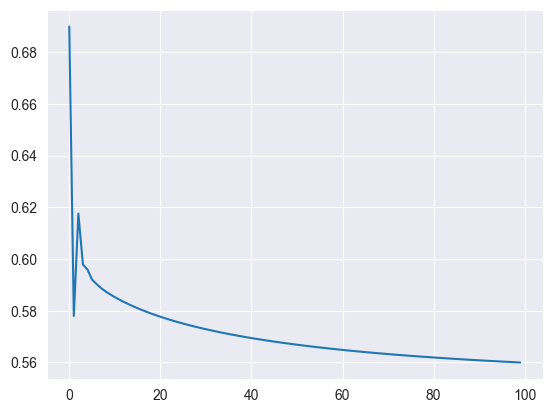

In [21]:
import matplotlib.pyplot as plt
concentrations = [conc['PyrPI'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [59]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

EI propagation results:  0.39006100453501935 simulation results:  decreased
PyrPI propagation results:  0.5614712860979437 simulation results:  increased
EIP propagation results:  0.5419299074204625 simulation results:  increased
HPr propagation results:  0.42302998398838354 simulation results:  decreased
EIPHPr propagation results:  0.4822127184106992 simulation results:  decreased
HPrP propagation results:  0.5727865972370842 simulation results:  increased
EIIA propagation results:  0.429865591464771 simulation results:  decreased
HPrPIIA propagation results:  0.5007764595124844 simulation results:  decreased
EIIAP propagation results:  0.5776508244635904 simulation results:  increased
EIICB propagation results:  0.4191452185607992 simulation results:  decreased
EIIAPIICB propagation results:  0.4981095704101313 simulation results:  decreased
EIICBP propagation results:  0.5659394200713055 simulation results:  increased
EIICBPGlc propagation results:  0.502126281483393 simulation res

In [2]:
res = complete_tests.complete_tests2(
            'BIOMD0000000038.xml',
            'BIOMOD0000000038_kf1_100x.xml',
            'description_v1_altered',
            []
        )

In [3]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0)

Specie:  EI expected result:  decreased
confidence interval:  [0.39292821511893017, 0.39565138140801437]
Specie:  PyrPI expected result:  increased
confidence interval:  [0.5799463689596592, 0.5807951916388906]
Specie:  EIP expected result:  increased
confidence interval:  [0.5497338452355615, 0.5535266257818298]
Specie:  HPr expected result:  decreased
confidence interval:  [0.434664218589784, 0.43733473571207293]
Specie:  EIPHPr expected result:  decreased
confidence interval:  [0.4869031821496546, 0.4880081595509908]
Specie:  HPrP expected result:  increased
confidence interval:  [0.5656706548053994, 0.5682838150684024]
Specie:  EIIA expected result:  decreased
confidence interval:  [0.4508403242412464, 0.4531129228813934]
Specie:  HPrPIIA expected result:  decreased
confidence interval:  [0.5012537160959607, 0.5018581637433419]
Specie:  EIIAP expected result:  increased
confidence interval:  [0.5495800000662362, 0.5517812238203322]
Specie:  EIICB expected result:  decreased
confide

In [4]:
total_count = 0
correct_count = 0
for specie in insights.keys():
    total_count += 1
    if insights[specie][0] == insights[specie][1]:
        correct_count += 1
print('total experiments: ', total_count, 'correct experiments: ', correct_count, 'ratio: ', correct_count/total_count)

total experiments:  17 correct experiments:  15 ratio:  0.8823529411764706


In [15]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  EI
 lower:  0.38702437497141556  higher:  0.3953636208975316
decrease, expected:  decreased
specie:  PyrPI
 lower:  0.577861018531099  higher:  0.5803421882908305
increase, expected:  unchanged
specie:  EIP
 lower:  0.5448553875432113  higher:  0.5577336062892596
increase, expected:  increased
specie:  HPr
 lower:  0.4308218096911517  higher:  0.43915205071853525
decrease, expected:  decreased
specie:  EIPHPr
 lower:  0.4853571550453938  higher:  0.48908389987964895
decrease, expected:  unchanged
specie:  HPrP
 lower:  0.5686229477900122  higher:  0.5769124583736869
increase, expected:  increased
specie:  EIIA
 lower:  0.4445298442942911  higher:  0.451633182968042
decrease, expected:  decreased
specie:  HPrPIIA
 lower:  0.5016945328731048  higher:  0.5040203445065157
increase, expected:  unchanged
specie:  EIIAP
 lower:  0.5513916879586308  higher:  0.5585219603059105
increase, expected:  increased
specie:  EIICB
 lower:  0.4539275436086541  higher:  0.4608547874566425
decrea

<Axes: ylabel='Count'>

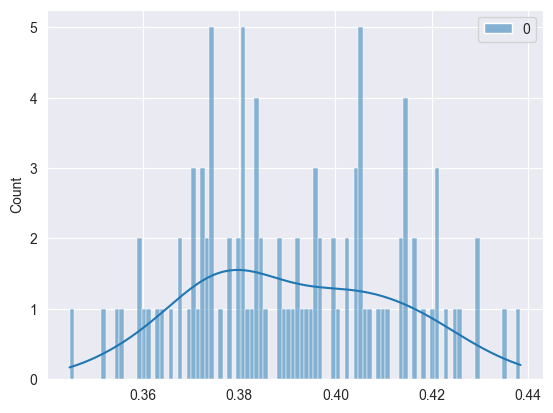

In [16]:
scores = np.array(insights[2]['EI'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)